### Hugo Englund | 2020-11-20


# Laboration 2: Part 2

## Outline
The outline for the second part of the laboration is as follows:
1. Take the best model from laboration 1 and convert at least five parameters to hyperparameters.
2. Use Keras Tuner to optimize these hyperparameters by the algorithms:
    - Random Search
    - Bayesian Search
3. Test the models immediately after tuning, after additional training and after training with resetted weights.
4. Create and tune an additional model with the number of dense layers as a hyperparameter as well.
5. Perform a complete analysis of the tuned models and their hyperparameters.
6. Compare the tuned models with each other, as well as against the model from laboration 1. 



### Import relevant packages

In [ ]:
# import kerastuner
try: 
    import kerastuner
except ModuleNotFoundError:
    !git clone https://github.com/keras-team/keras-tuner.git
    !pip install ./keras-tuner

import kerastuner
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import BayesianOptimization

In [ ]:
# import relevant packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


### (Performance plot function)

In [ ]:
# plots accuracy and loss for training and validation, respectively
def plot_performance(history):
  # plot accuracy during training and validation
  plt.plot(history.history["accuracy"], label="Training\naccuracy")
  plt.plot(history.history["val_accuracy"], label="Validation\naccuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.ylim([0, 1])
  plt.legend(loc="best")
  plt.title("Training and validation accuracies")
  plt.grid(b=True)
  plt.show()

  # plot loss during training and validation
  plt.plot(history.history["loss"], label="Training\nloss")
  plt.plot(history.history["val_loss"], label='Validation\nloss')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.ylim([0, 1])
  plt.legend(loc="best")
  plt.title("Training and validation losses")
  plt.grid(b=True)
  plt.show()
  return

### (Reset weights function)

In [ ]:
# code to reset model weights in TF2, from https://github.com/keras-team/keras/issues/341
def reset_weights(model):
  for layer in model.layers: 
    if isinstance(layer, tf.keras.Model):
      reset_weights(layer)
      continue
    for k, initializer in layer.__dict__.items():
      if "initializer" not in k:
        continue
      # find the corresponding variable
      var = getattr(layer, k.replace("_initializer", ""))
      var.assign(initializer(var.shape, var.dtype))

### Fetch and prepare data

In [ ]:
from keras.utils.np_utils import to_categorical

# fetch data
fashion_mnist = tf.keras.datasets.fashion_mnist

# Save class names since they are not included in the imported data set
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# load data and split to train and test sets
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# normalize image pixels
train_images, test_images = train_images / 255.0, test_images / 255.0

# reshape images to have "RGB-channel"
train_images, test_images = train_images.reshape(60000, 28, 28, 1), test_images.reshape(10000, 28, 28, 1)

# convert labels to one-hot encoded vectors
train_labels, test_labels = to_categorical(train_labels, num_classes=10), to_categorical(test_labels, num_classes=10)

### Adjust the model to have tunable hyperparameters
Adjust the main model from laboration 1 to have tunable hyperparameters. The following will be converted to hyperparameters, in some parts of the model, and tuned:
1. Kernel size
2. Filter size
3. Learning rate
4. Dropout rate
5. Number of units in the first dense layer


In [ ]:
# import relevant layers and optimizer
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.optimizers import SGD

# function to create a CNN on the run
def init_cnn(hp): 
    # initiate model
    cnn = tf.keras.Sequential()

    # define filter size for first pair of convolutional layers
    n_filters_1 = hp.Int('conv_1_filter', min_value=32, max_value=256, default=32, step=32)

    # define kernel size for first pair of convolutional layers
    n_kernels_1 = hp.Choice('conv_1_kernel', values = [3,5])

    # define common dropout rate after each pair of convolutional layers
    do_rate = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)

    # input layer
    cnn.add(Conv2D(
        filters=n_filters_1,
        kernel_size=n_kernels_1,
        input_shape=(28, 28, 1),
        padding="same",
        activation="relu"))
    
    cnn.add(Conv2D(
        filters=n_filters_1,
        kernel_size=n_kernels_1,
        padding="same",
        activation="relu"))
    
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D(pool_size=(2,2)))

    cnn.add(Dropout(rate=do_rate))

    # define filter size for second pair of convolutional layers
    n_filters_2 = hp.Int('conv_2_filter', min_value=64, max_value=512, default=64, step=64)

    # define kernel size for second pair of convolutional layers
    n_kernels_2 = hp.Choice('conv_2_kernel', values = [3,5])

    # convolutional layer 
    cnn.add(Conv2D(
                filters=n_filters_2,
                kernel_size=n_kernels_2,
                padding="same",
                activation="relu"))
    
    cnn.add(BatchNormalization())

    cnn.add(Conv2D(
                filters=n_filters_2,
                kernel_size=n_kernels_2,
                padding="same",
                activation="relu"))
    
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D(pool_size=(2,2)))

    cnn.add(Dropout(rate=do_rate))

    # flatten to enable prediction
    cnn.add(Flatten())

    # dense layer
    cnn.add(Dense(
        units=hp.Int(
            'main_dense_units', 
            min_value=256, 
            max_value=1024,
            step=256),
        activation="relu"))
    
    cnn.add(BatchNormalization())

    cnn.add(Dropout(0.5))

    # output layer with softmax activation
    cnn.add(Dense(10, activation="softmax"))

    # define options for learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

    # define optimizer 
    optimizer = SGD(
        lr=learning_rate, 
        momentum=0.9, 
        nesterov=True,
        decay=learning_rate/15) # divided by 15 due to 15 epochs in tuning

    # compile the model
    cnn.compile(optimizer=optimizer, 
                loss="categorical_crossentropy", 
                metrics=["accuracy"])
    return cnn

### Perform Random Search

In [ ]:
trials = 10 # Total number of model configs 
exec = 2 # number of models per trial

# init random search
tuner = RandomSearch(
    init_cnn,
    objective='val_accuracy',
    max_trials=trials,
    executions_per_trial=exec,
    directory='random_search',
    project_name='FashionMNIST_RS0'
)

In [ ]:
# perform random search
batch_size = 100
n_epochs = 15
tuner.search(
    train_images, 
    train_labels, 
    epochs=n_epochs, 
    validation_split=1/6, 
    batch_size=batch_size,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
)

Trial 10 Complete [00h 05m 12s]
val_accuracy: 0.9206500053405762

Best val_accuracy So Far: 0.9315000176429749
Total elapsed time: 00h 44m 31s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# obtain the best model from the random search
model_RS = tuner.get_best_models(num_models=1)[0]

# print the "best" hyperparameters
vals = tuner.get_best_hyperparameters()[0].values
for k, v in vals.items():
    print("%20s = %3.4g" %(k, v))

# Print the model sumary
model_RS.summary()

       conv_1_filter = 128
       conv_1_kernel =   3
             dropout = 0.05
       conv_2_filter = 384
       conv_2_kernel =   3
    main_dense_units = 256
       learning_rate = 0.01
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0         
_______________________________________________________________

In [ ]:
# test the model before proceeding with additional training
test_loss, test_acc = model_RS.evaluate(test_images, test_labels, verbose=0)
print("Test loss: {0:.{1}}".format(test_loss, 4))
print("Test accuracy: {0:.{1}}\n".format(test_acc, 4))

Test loss: 0.2054
Test accuracy: 0.9281



In [ ]:
# define parameters for continued training
epochs = 30
batch_size = 100

# apply early stopping
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2)]

# Continue to train the model (note that we are continuing from the training done during tuning)
hist_RS = model_RS.fit(
  train_images, train_labels,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_split=1/6,
  callbacks=callbacks
)

Epoch 1/30
500/500 [==============================] - 9s 19ms/step - loss: 0.1372 - accuracy: 0.9505 - val_loss: 0.2183 - val_accuracy: 0.9209
Epoch 2/30
500/500 [==============================] - 9s 18ms/step - loss: 0.1280 - accuracy: 0.9540 - val_loss: 0.1920 - val_accuracy: 0.9325
Epoch 3/30
500/500 [==============================] - 9s 18ms/step - loss: 0.1174 - accuracy: 0.9577 - val_loss: 0.2089 - val_accuracy: 0.9242
Epoch 4/30
500/500 [==============================] - 9s 18ms/step - loss: 0.1075 - accuracy: 0.9613 - val_loss: 0.2052 - val_accuracy: 0.9304
Epoch 00004: early stopping


In [ ]:
# test the model before "fresh" training session
test_loss, test_acc = model_RS.evaluate(test_images, test_labels, verbose=0)
print("Test loss: {0:.{1}}".format(test_loss, 4))
print("Test accuracy: {0:.{1}}\n".format(test_acc, 4))

Test loss: 0.2302
Test accuracy: 0.9241



In [ ]:
# reset weights to random values
reset_weights(model_RS)

In [ ]:
# apply early stopping
early_stop = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2)]

# train the model
hist_RS_reset = model_RS.fit(
  train_images, train_labels,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_split=1/6,
  callbacks=early_stop
)

Epoch 1/30
500/500 [==============================] - 9s 19ms/step - loss: 0.4987 - accuracy: 0.8265 - val_loss: 0.6796 - val_accuracy: 0.7568
Epoch 2/30
500/500 [==============================] - 9s 18ms/step - loss: 0.3296 - accuracy: 0.8828 - val_loss: 0.2570 - val_accuracy: 0.9061
Epoch 3/30
500/500 [==============================] - 9s 18ms/step - loss: 0.2706 - accuracy: 0.9027 - val_loss: 0.2548 - val_accuracy: 0.9063
Epoch 4/30
500/500 [==============================] - 9s 18ms/step - loss: 0.2392 - accuracy: 0.9143 - val_loss: 0.2336 - val_accuracy: 0.9127
Epoch 5/30
500/500 [==============================] - 9s 19ms/step - loss: 0.2153 - accuracy: 0.9225 - val_loss: 0.2260 - val_accuracy: 0.9161
Epoch 6/30
500/500 [==============================] - 9s 18ms/step - loss: 0.1989 - accuracy: 0.9296 - val_loss: 0.2256 - val_accuracy: 0.9168
Epoch 7/30
500/500 [==============================] - 9s 19ms/step - loss: 0.1819 - accuracy: 0.9355 - val_loss: 0.2189 - val_accuracy: 0.9213

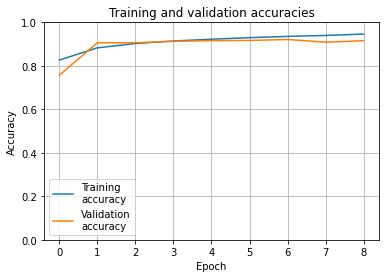

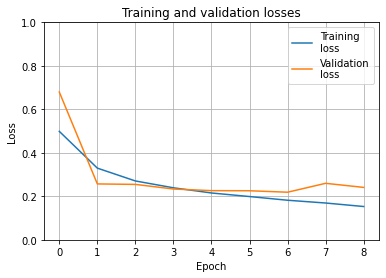

In [ ]:
# visualize performance of the re-trained model
plot_performance(hist_RS_reset)

In [ ]:
# test the model after resetting weights
test_loss, test_acc = model_RS.evaluate(test_images, test_labels, verbose=0)
print("Test loss: {0:.{1}}".format(test_loss, 4))
print("Test accuracy: {0:.{1}}\n".format(test_acc, 4))

Test loss: 0.2583
Test accuracy: 0.9084



### Perform Bayesian Optimazation
This optimization procedure also tunes the batch size.

In [ ]:
# define tuner in order to have batch size as a hyperparameter
class MyTuner(kerastuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 512, step=32)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
# define input for tuning
trials = 10 
exec = 2

# create tuner object
tuner = MyTuner(
    init_cnn, 
    max_trials=trials,
    objective='val_accuracy',
    executions_per_trial=exec,
    directory='bayesian_optimization',
    project_name='FashionMNIST_BO0'
)

In [ ]:
# apply early stop training
early_stop = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2)]

n_epochs = 15
# perform the search
tuner.search(
    train_images, 
    train_labels, 
    epochs=n_epochs, 
    validation_split=1/6, 
    callbacks=early_stop
)

Trial 10 Complete [00h 02m 54s]
val_accuracy: 0.9191499948501587

Best val_accuracy So Far: 0.9284999966621399
Total elapsed time: 00h 34m 28s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# obtain best model based on the bayesian optimization
model_BO = tuner.get_best_models(num_models=1)[0]

# print out the "best" hyperparameters
vals = tuner.get_best_hyperparameters(num_trials=5)[4].values
for k, v in vals.items():
    print("%20s = %3.4g" %(k, v))
    
model_BO.summary()

       conv_1_filter = 224
       conv_1_kernel =   3
             dropout = 0.1
       conv_2_filter = 256
       conv_2_kernel =   3
    main_dense_units = 1024
       learning_rate = 0.01
          batch_size = 416
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
____________________________________

In [ ]:
# test the model before additional training
test_loss, test_acc = model_BO.evaluate(test_images, test_labels, verbose=0)
print("Test loss: {0:.{1}}".format(test_loss, 4))
print("Test accuracy: {0:.{1}}\n".format(test_acc, 4))

Test loss: 0.2275
Test accuracy: 0.9245



In [ ]:
# define parameters for additional training
epochs = 30
opt_batch_size = tuner.get_best_hyperparameters()[0]['batch_size']

# apply early stop training
early_stop = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2)]

# proceed training
hist_BO = model_BO.fit(
  train_images, train_labels,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_split=1/6,
  callbacks=early_stop
)

Epoch 1/30
521/521 [==============================] - 4s 9ms/step - loss: 0.0921 - accuracy: 0.9670 - val_loss: 0.2268 - val_accuracy: 0.9239
Epoch 2/30
521/521 [==============================] - 4s 8ms/step - loss: 0.0818 - accuracy: 0.9714 - val_loss: 0.2204 - val_accuracy: 0.9301
Epoch 3/30
521/521 [==============================] - 4s 8ms/step - loss: 0.0726 - accuracy: 0.9742 - val_loss: 0.2173 - val_accuracy: 0.9292
Epoch 4/30
521/521 [==============================] - 4s 8ms/step - loss: 0.0643 - accuracy: 0.9768 - val_loss: 0.2210 - val_accuracy: 0.9305
Epoch 5/30
521/521 [==============================] - 4s 8ms/step - loss: 0.0589 - accuracy: 0.9793 - val_loss: 0.2275 - val_accuracy: 0.9302
Epoch 00005: early stopping


In [ ]:
# test the model
test_loss, test_acc = model_BO.evaluate(test_images, test_labels, verbose=0)
print("Test loss: {0:.{1}}".format(test_loss, 4))
print("Test accuracy: {0:.{1}}\n".format(test_acc, 4))

Test loss: 0.2433
Test accuracy: 0.9305



In [ ]:
# reset weights to random values
reset_weights(model_BO)

In [ ]:
# apply early stopping
early_stop = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2)]

# train the model
hist_BO_reset = model_BO.fit(
  train_images, train_labels,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_split=1/6,
  callbacks=early_stop
)

Epoch 1/30
521/521 [==============================] - 4s 8ms/step - loss: 0.5020 - accuracy: 0.8325 - val_loss: 0.5778 - val_accuracy: 0.7911
Epoch 2/30
521/521 [==============================] - 4s 8ms/step - loss: 0.3181 - accuracy: 0.8878 - val_loss: 0.2860 - val_accuracy: 0.8952
Epoch 3/30
521/521 [==============================] - 4s 8ms/step - loss: 0.2645 - accuracy: 0.9053 - val_loss: 0.2428 - val_accuracy: 0.9138
Epoch 4/30
521/521 [==============================] - 4s 9ms/step - loss: 0.2278 - accuracy: 0.9172 - val_loss: 0.2345 - val_accuracy: 0.9165
Epoch 5/30
521/521 [==============================] - 4s 8ms/step - loss: 0.2049 - accuracy: 0.9238 - val_loss: 0.2629 - val_accuracy: 0.9035
Epoch 6/30
521/521 [==============================] - 4s 8ms/step - loss: 0.1823 - accuracy: 0.9336 - val_loss: 0.2224 - val_accuracy: 0.9203
Epoch 7/30
521/521 [==============================] - 4s 8ms/step - loss: 0.1651 - accuracy: 0.9405 - val_loss: 0.2403 - val_accuracy: 0.9150
Epoch 

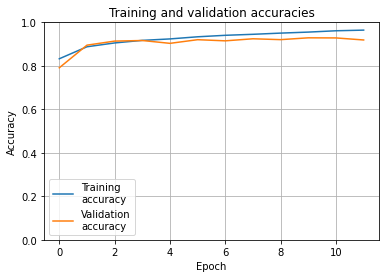

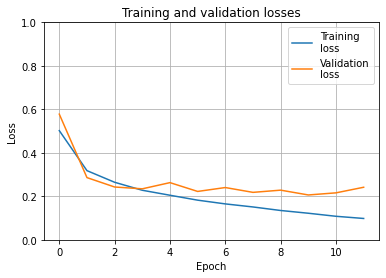

In [ ]:
# visualize performance of the optimal "Bayesian" model
plot_performance(hist_BO_reset)

In [ ]:
# test the model after the "fresh" training
test_loss, test_acc = model_BO.evaluate(test_images, test_labels, verbose=0)
print("Test loss: {0:.{1}}".format(test_loss, 4))
print("Test accuracy: {0:.{1}}\n".format(test_acc, 4))

Test loss: 0.2627
Test accuracy: 0.9107



### Experiment with additional dense layers
Now we add additional dense layers after the existing one, and apply Bayesian optimization to examine if we can obtain a better model.

In [ ]:
# import relevant layers and optimizer
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.optimizers import SGD

# function to create a CNN on the run
def init_cnn_AL(hp): 
    # initiate model
    cnn = tf.keras.Sequential()

    # define filter size for first pair of convolutional layers
    n_filters_1 = hp.Int('conv_1_filter', min_value=32, max_value=256, default=32, step=32)

    # define kernel size for first pair of convolutional layers
    n_kernels_1 = hp.Choice('conv_1_kernel', values = [3,5])

    # define common dropout rate after each pair of convolutional layers
    do_rate = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)

    # input layer
    cnn.add(Conv2D(
        filters=n_filters_1,
        kernel_size=n_kernels_1,
        input_shape=(28, 28, 1),
        padding="same",
        activation="relu"))
    
    cnn.add(Conv2D(
        filters=n_filters_1,
        kernel_size=n_kernels_1,
        padding="same",
        activation="relu"))
    
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D(pool_size=(2,2)))

    cnn.add(Dropout(rate=do_rate))

    # define filter size for second pair of convolutional layers
    n_filters_2 = hp.Int('conv_2_filter', min_value=64, max_value=512, default=64, step=64)

    # define kernel size for second pair of convolutional layers
    n_kernels_2 = hp.Choice('conv_2_kernel', values = [3,5])

    # convolutional layer 
    cnn.add(Conv2D(
                filters=n_filters_2,
                kernel_size=n_kernels_2,
                padding="same",
                activation="relu"))
    
    cnn.add(BatchNormalization())

    cnn.add(Conv2D(
                filters=n_filters_2,
                kernel_size=n_kernels_2,
                padding="same",
                activation="relu"))
    
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D(pool_size=(2,2)))

    cnn.add(Dropout(rate=do_rate))

    # flatten to enable prediction
    cnn.add(Flatten())

    # dense layer
    cnn.add(Dense(
        units=hp.Int(
            'main_dense_units', 
            min_value=256, 
            max_value=1024,
            step=256),
        activation="relu"))
    
    cnn.add(BatchNormalization())

    cnn.add(Dropout(0.5))
    
    # define potential additional dense layers
    for i in range(hp.Int('num_layers', 1, 2)):
        cnn.add(Dense(units=hp.Int('unit_' + str(i),
                                    min_value=32,
                                    max_value=512,
                                    step=64),
                            activation='relu'))

    # output layer with softmax activation
    cnn.add(Dense(10, activation="softmax"))

    # define options for learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

    # define optimizer 
    optimizer = SGD(
        lr=learning_rate, 
        momentum=0.9, 
        nesterov=True,
        decay=learning_rate/15) # divided by 15, due to 15 epochs in tuning

    # compile the model
    cnn.compile(optimizer=optimizer, 
                loss="categorical_crossentropy", 
                metrics=["accuracy"])
    return cnn

In [ ]:
# define input for tuning
trials = 10 
exec = 2

# create tuner object
tuner = MyTuner(
    init_cnn_AL, 
    max_trials=trials,
    objective='val_accuracy',
    executions_per_trial=exec,
    directory='bayesian_optimization',
    project_name='FashionMNIST_AL0'
)

In [ ]:
# apply early stop training
early_stop = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2)]

n_epochs = 15
# perform the search
tuner.search(
    train_images, 
    train_labels, 
    epochs=n_epochs, 
    validation_split=1/6, 
    callbacks=early_stop
)

Trial 10 Complete [00h 00m 51s]
val_accuracy: 0.540649987757206

Best val_accuracy So Far: 0.934249997138977
Total elapsed time: 00h 38m 43s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# obtain best model based on the bayesian optimization with additional layers
model_AL = tuner.get_best_models(num_models=1)[0]

# print out the "best" hyperparameters
vals = tuner.get_best_hyperparameters(num_trials=5)[4].values
for k, v in vals.items():
    print("%20s = %3.4g" %(k, v))
    
model_AL.summary()

       conv_1_filter =  32
       conv_1_kernel =   3
             dropout = 0.5
       conv_2_filter = 512
       conv_2_kernel =   3
    main_dense_units = 256
          num_layers =   1
              unit_0 =  32
       learning_rate = 0.01
          batch_size = 512
              unit_1 = 480
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)     

In [ ]:
# test the model before additional training
test_loss, test_acc = model_AL.evaluate(test_images, test_labels, verbose=0)
print("Test loss: {0:.{1}}".format(test_loss, 4))
print("Test accuracy: {0:.{1}}\n".format(test_acc, 4))

Test loss: 0.2037
Test accuracy: 0.9291



In [ ]:
# define parameters for additional training
epochs = 30
opt_batch_size = tuner.get_best_hyperparameters()[0]['batch_size']

# apply early stop training
early_stop = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2)]

# proceed training
hist_AL = model_AL.fit(
  train_images, train_labels,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_split=1/6,
  callbacks=early_stop
)

Epoch 1/30
1563/1563 [==============================] - 15s 9ms/step - loss: 0.1332 - accuracy: 0.9519 - val_loss: 0.1861 - val_accuracy: 0.9344
Epoch 2/30
1563/1563 [==============================] - 15s 9ms/step - loss: 0.1201 - accuracy: 0.9557 - val_loss: 0.1976 - val_accuracy: 0.9336
Epoch 3/30
1563/1563 [==============================] - 15s 9ms/step - loss: 0.1056 - accuracy: 0.9623 - val_loss: 0.1992 - val_accuracy: 0.9348
Epoch 00003: early stopping


In [ ]:
# test the model after additional training
test_loss, test_acc = model_AL.evaluate(test_images, test_labels, verbose=0)
print("Test loss: {0:.{1}}".format(test_loss, 4))
print("Test accuracy: {0:.{1}}\n".format(test_acc, 4))

Test loss: 0.2121
Test accuracy: 0.9279



In [ ]:
# reset weights to random values
reset_weights(model_AL)

In [ ]:
# apply early stopping
early_stop = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2)]

# train the model
hist_AL_reset = model_AL.fit(
  train_images, train_labels,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_split=1/6,
  callbacks=early_stop
)

Epoch 1/30
1563/1563 [==============================] - 15s 9ms/step - loss: 0.5008 - accuracy: 0.8214 - val_loss: 0.3165 - val_accuracy: 0.8862
Epoch 2/30
1563/1563 [==============================] - 15s 9ms/step - loss: 0.3367 - accuracy: 0.8792 - val_loss: 0.3436 - val_accuracy: 0.8686
Epoch 3/30
1563/1563 [==============================] - 15s 10ms/step - loss: 0.2865 - accuracy: 0.8963 - val_loss: 0.2494 - val_accuracy: 0.9111
Epoch 4/30
1563/1563 [==============================] - 15s 9ms/step - loss: 0.2513 - accuracy: 0.9101 - val_loss: 0.2445 - val_accuracy: 0.9119
Epoch 5/30
1563/1563 [==============================] - 15s 9ms/step - loss: 0.2260 - accuracy: 0.9181 - val_loss: 0.2163 - val_accuracy: 0.9185
Epoch 6/30
1563/1563 [==============================] - 15s 10ms/step - loss: 0.2093 - accuracy: 0.9248 - val_loss: 0.2153 - val_accuracy: 0.9235
Epoch 7/30
1563/1563 [==============================] - 15s 10ms/step - loss: 0.1900 - accuracy: 0.9301 - val_loss: 0.2066 - val

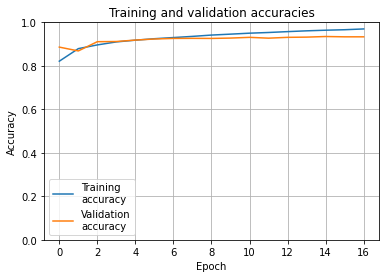

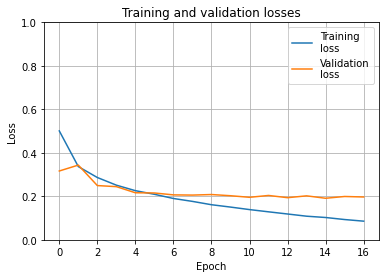

In [ ]:
# visualize performance of the optimal "Bayesian" model with additional layers
plot_performance(hist_AL_reset)

In [ ]:
# test the model after fresh training
test_loss, test_acc = model_AL.evaluate(test_images, test_labels, verbose=0)
print("Test loss: {0:.{1}}".format(test_loss, 4))
print("Test accuracy: {0:.{1}}\n".format(test_acc, 4))

Test loss: 0.2007
Test accuracy: 0.9344



## Results & Discussion
We can start off by recalling the parameter values that were used in the first laboration, along with those found by Random search and Bayesian optimization. 



### Summary of parameter values 
#### Laboration 1 | (Hyper)parameter values
For the first pair of convolutional layers:
- Filter size: 32
- Kernel size: 3x3
- Dropout rate: 0.25

For the second pair of convolutional layers:
- Filter size: 64
- Kernel size: 3x3
- Dropout rate: 0.25

Other parameters:
- Batch size: 100
- Learning rate: 0.01
- Units in dense layer: 512

Performance after training:
- Test loss: 0.2154
- Test accuracy: 0.9212
- Fit: Good fit

#### Random Search | Hyperparameter values 
For the first pair of convolutional layers:
- Filter size: 128
- Kernel size: 3x3
- Dropout rate: 0.05

For the second pair of convolutional layers:
- Filter size: 384
- Kernel size: 3x3
- Dropout rate: 0.05

Other parameters:
- Batch size: 100 (not tuned)
- Learning rate: 0.01
- Units in dense layer: 256

Performance (after fresh training):
- Test loss: 0.2583
- Test accuracy: 0.9084
- Fit: Overfitted

#### Bayesian Optimization | Hyperparameter values  
For the first pair of convolutional layers:
- Filter size: 224
- Kernel size: 3x3
- Dropout rate: 0.1

For the second pair of convolutional layers:
- Filter size: 256
- Kernel size: 3x3
- Dropout rate: 0.1

Other parameters:
- Batch size: 416
- Learning rate: 0.01
- Units in dense layer: 1024

Performance (after fresh training):
- Test loss: 0.2627
- Test accuracy: 0.9107
- Fit: Overfitted

#### Bayesian Optimization + two dense layers | Hyperparameter values
For the first pair of convolutional layers:
- Filter size: 32
- Kernel size: 3x3
- Dropout rate: 0.5

For the second pair of convolutional layers:
- Filter size: 512
- Kernel size: 3x3
- Dropout rate: 0.5

First additonal dense layer:
- Units: 32

Second additonal dense layer:
- Units: 480

Other parameters:
- Batch size: 512
- Learning rate: 0.01
- Units in dense layer: 256

Performance (after fresh training):
- Test loss: 0.2007
- Test accuracy: 0.9344
- Fit: Overfitted

### Comparison
If we start by comparing the model from laboration 1 with three tuned models, the general trend is that tuner tend to increase the size of the model by shifiting towards larger filters and more units in the dense layer. Moreover, the tuned filters was smaller for the first convolutional layers and then larger for the second one. On the other hand, in the last model, the number of units in the dense layers started with 256, then 32 and lastly 480, i.e. no pattern at all. Based on these findings, the size-related hyperparameters seemed to be the most important ones in relation to kernel size, dropout and learning rate. However, the filter size and number of dense layer units had a relatively wide range of possible values within each layer, in combination with multiple such layers, which can be the reason to their "importance". With less combinations of these, their impact most likely would decrease.  

Furthermore, the parameter values that stayed the same througout all models were the learning rate of 0.01 and kernel size of 3x3. This indicates that these values were a good choice with laboration 1 in mind. On the contrary, the dropout rate after each pair of convolutional layers was different in each model. The inital rate of 0.25 decreased to 0.05 in the Random search, to 0.1 in the first Bayesian optimization, and then increased to 0.5 in the second Bayesian optimization. In addition, the tuned batch sizes, in the Bayesian models, were substantially larger than the inital size of 100, with 416 and 512, respecitvely. This might be an indication that my initial batch size was too small, but we have to keep in mind that these are quite different models. 

Besides that, it were quite few times the hyperparameter reached the boundary. In the first tuned model, all parameters was inside the predefined boundaries. In the second one, the number of units in the dense layers reached the maximum value. In the third one, the second pair of convolutional layers and the dropout rate reached their maximum values. The parameters on the boundary indicates that they have been too restricted and it is likely that their corresponding model would have improved with higher limits in this case. On the other hand, parameters that affects the size of the model generally increases the training time and this trade-off has to be considered when relaxing upper boundaries.  However, I believe that a dropout above 0.5 early in the model is too aggressive and thus not preferable.

Regarding the performance of the tuned models in relation to model in laboration 1, we can see that all of the tuned models are more or less overfitted. Thus, it is hard to believe that these have generalized well. Moreover, the two first models had a worse test loss, as well as test accuracy, compared to the model in Laboration 1. Although the third model was overfitted, it performed best in both aspects.

Lastly, it cannot be stressed enough that the tuned models have restrictions that perhaps not are suitable for this particular problem at all. Since I restricted the hyperparameters to result in models with similar architecture as the one made in Laboration 1, I might trapped myself. On the other hand, the experimentation and analysis made in this laboration is not sufficient to dismiss my model, since far from all combinations of hyperparameters have been tested, and those tested have only been ran two times.